# Mental Health Text Classification
This notebook applies classic machine learning techniques to classify mental health-related text into categories such as Anxiety, Depression, and Suicidal.

We use:
- TF-IDF for text vectorization
- Multiple traditional ML models
- A unified training and evaluation function


In [1]:
%matplotlib inline

import plotly.io as pio
pio.renderers.default = "svg"


In [2]:
import sys
sys.path.append('../src')

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from model import train_and_evaluate
from sklearn.preprocessing import LabelEncoder
import json
from sklearn.model_selection import GridSearchCV, cross_val_score


### Load Dataset
We load the mental health text dataset. Each row contains a text sample and its corresponding mental health label.


In [4]:
data = pd.read_csv(r'C:\Users\Rubah\OneDrive\سطح المكتب\MLmodels\data\mental_health_combined_test.csv')

data.head()

,text,status
0,i don't understand whats wrong with me. i don'...,Anxiety
1,usually when i have anxiety just chatting with...,Anxiety
2,"well, i've had anxiety and panic syndrome for ...",Anxiety
3,"for the most minimal of things, like standing ...",Anxiety
4,i stay away from family and live with my roomm...,Anxiety


### Dataset Overview
We inspect the dataset structure and check for missing values.


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    992 non-null    object
 1   status  992 non-null    object
dtypes: object(2)
memory usage: 15.6+ KB


In [6]:
data.isnull().sum()

text      0
status    0
dtype: int64

### Text Vectorization
Machine learning models require numerical input.  
We convert text into numbers using **TF-IDF**, which measures how important each word is in a document relative to the dataset.


In [7]:
le = LabelEncoder()
y = le.fit_transform(data['status'])   
X_text = data['text']

In [8]:
label_ids = list(range(len(le.classes_)))
label_names = list(le.classes_)
mapping = {int(i): str(name) for i, name in enumerate(label_names)}

In [9]:
with open("mental_health_label_mapping.json", "w") as f:
    json.dump(mapping, f)
print("Saved label mapping:", mapping)

Saved label mapping: {0: 'Anxiety', 1: 'Depression', 2: 'Normal', 3: 'Suicidal'}


In [10]:
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=10000,
    ngram_range=(1,2), 
    lowercase=True,
    min_df=2,
    max_df=0.95
)
X = tfidf.fit_transform(X_text)

### Models
We evaluate multiple classic machine learning models:
- Logistic Regression
- Linear SVM
- Naive Bayes
- Baseline (most frequent class)


In [11]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(),
    "Naive Bayes": MultinomialNB(),
    "Baseline": DummyClassifier(strategy="most_frequent")
}


In [12]:
param_grids = {
    "Logistic Regression": {
        "C": [0.1, 1, 5],
        "solver": ["lbfgs", "liblinear"]
    },
    "Linear SVM": {
        "C": [0.1, 1, 5]
    },
    "Naive Bayes": {
        "alpha": [0.5, 1.0, 1.5]
    },
    "Baseline": {}
}

### Train and Evaluate Models
We use a single unified function to:
- split the data
- train the model
- evaluate performance
- visualize confusion matrices



Training Logistic Regression...


c:\Users\Rubah\OneDrive\سطح المكتب\MLmodels\venv\Lib\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning:


15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Rubah\OneDrive\سطح المكتب\MLmodels\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Rubah\OneDrive\سطح المكتب\MLmodels\venv\Lib\site-packages\sklearn\base.py", line 1336, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Rubah\OneDrive\سطح المكتب\MLm

Best params for Logistic Regression: {'C': 5, 'solver': 'lbfgs'}
5-Fold CV Accuracy for Logistic Regression: 0.6915


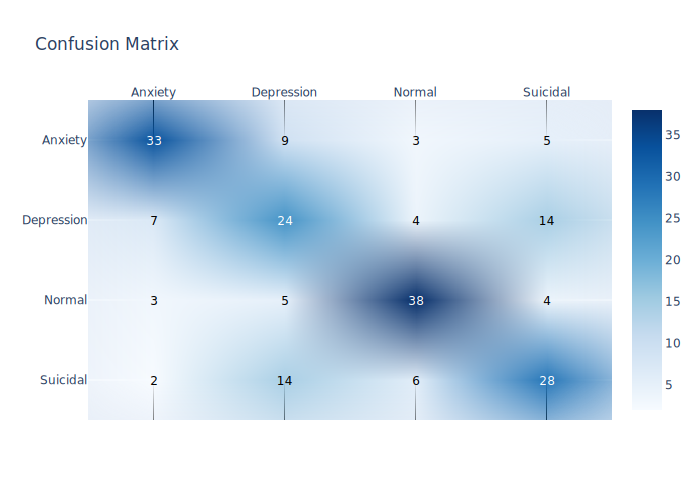


Training Linear SVM...
Best params for Linear SVM: {'C': 1}
5-Fold CV Accuracy for Linear SVM: 0.6804


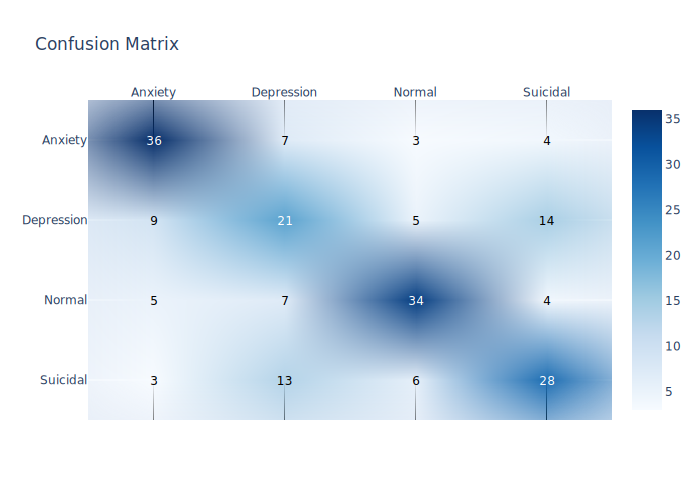


Training Naive Bayes...
Best params for Naive Bayes: {'alpha': 0.5}
5-Fold CV Accuracy for Naive Bayes: 0.6018


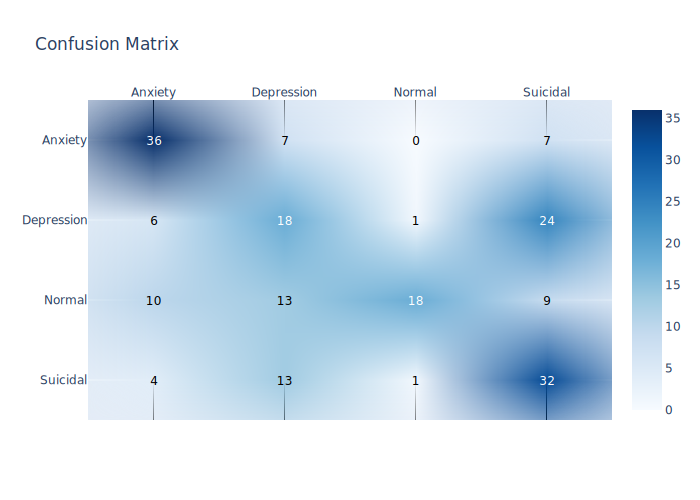


Training Baseline...
5-Fold CV Accuracy for Baseline: 0.2470


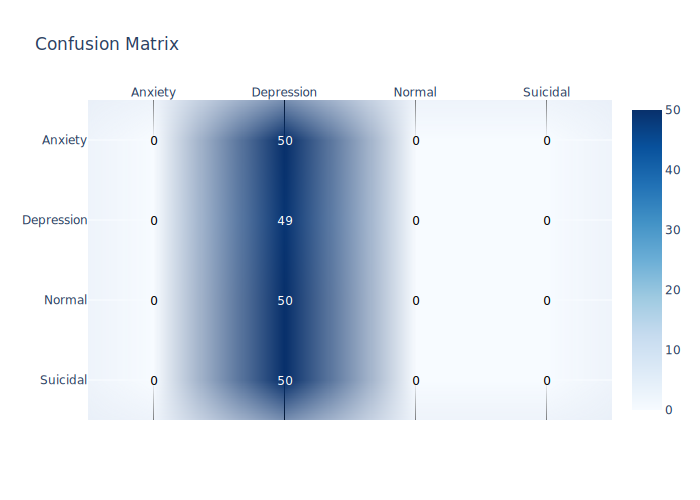

In [13]:
metrics_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    if name != "Baseline" and param_grids[name]:
        grid = GridSearchCV(
            model,
            param_grids[name],
            cv=5,
            scoring='accuracy',
            n_jobs=-1
        )
        grid.fit(X, y)
        best_model = grid.best_estimator_
        print(f"Best params for {name}: {grid.best_params_}")
    else:
        best_model = model

    cv_score = cross_val_score(best_model, X, y, cv=5, scoring='accuracy').mean()
    print(f"5-Fold CV Accuracy for {name}: {cv_score:.4f}")

    metrics = train_and_evaluate(
        best_model,
        X,
        y,
        task="classification",
        labels=label_ids,
        class_names=label_names,
        plot=True
    )
    
    metrics['CV Accuracy'] = cv_score
    metrics_results[name] = metrics


### Model Performance Comparison
We compare accuracy, precision, recall, and F1-score across all models.


In [14]:
results_df = pd.DataFrame(metrics_results).T
results_df.round(4)

,Accuracy,Precision,Recall,F1 Score,CV Accuracy
Logistic Regression,0.6181,0.6231,0.6181,0.6200,0.6915
Linear SVM,0.5980,0.5971,0.5980,0.5973,0.6804
Naive Bayes,0.5226,0.5862,0.5226,0.5203,0.6018
Baseline,0.2462,0.0606,0.2462,0.0973,0.2470


In [15]:
import os
from joblib import dump

os.makedirs("models", exist_ok=True)

best_model_name = 'Logistic Regression'
best_model = models[best_model_name]
best_model_name = 'Logistic Regression_Mental_Health'
model_path = f"models/{best_model_name.replace(' ', '_')}.joblib"
dump(best_model, model_path)

print(f"Saved {best_model_name} as '{model_path}'")

Saved Logistic Regression_Mental_Health as 'models/Logistic_Regression_Mental_Health.joblib'
